# Defining Our Strategy To Preprocess Our Data

We need to process our data before we can feed it into any ML model. We also have to perform whatever preprocessing steps that we take here, into the testing notebook when we are predicting on our test data. 

Our main goal is "Reusability"; as such we will be creating functions for each preprocessing steps that we take. In this way we will only need to call our functions on the predict.ipny notebook to do the same preprocessing steps.

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from scipy.stats import zscore
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
pd.set_option('display.max_columns',None)
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
excel_file_path = '../../Data/Raw/INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.xls'
df = pd.read_excel(excel_file_path).drop(['EmpNumber'],axis=1)
df.head()

,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,EmpJobSatisfaction,NumCompaniesWorked,OverTime,EmpLastSalaryHikePercent,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,32,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,10,3,4,55,3,2,4,1,No,12,4,10,2,2,10,7,0,8,No,3
1,47,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,14,4,4,42,3,2,1,2,No,12,4,20,2,3,7,7,1,7,No,3
2,40,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Frequently,5,4,4,48,2,3,1,5,Yes,21,3,20,2,3,18,13,1,12,No,4
3,41,Male,Human Resources,Divorced,Human Resources,Manager,Travel_Rarely,10,4,2,73,2,5,4,3,No,15,2,23,2,2,21,6,12,6,No,3
4,60,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,16,4,1,84,3,2,1,8,No,14,4,10,1,3,2,2,2,2,No,3


# Test Set That Will Used Only for Model Evaluation

In [3]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [4]:
train_df.shape ,test_df.shape

((960, 27), (240, 27))

In [5]:
import pandas as pd
import os

output_folder = os.path.join('..', '..', 'Data', 'Raw')
output_file_path = os.path.join(output_folder, 'test_df.csv')
test_df.to_csv(output_file_path, index=False)

# Handling Missing Values

In [6]:
df = train_df

In [7]:
df.shape

(960, 27)

In [8]:
def handle_missing(dataframe):
    import pandas as pd
    missing_data_cols = dataframe.columns[dataframe.isnull().sum() > 0]
    null = dataframe.isnull().sum()
    null_df = pd.DataFrame(null, columns=["No_of_null_values"])
    null_df = null_df.loc[missing_data_cols]
    
    if len(null_df) > 0:
        for col in null_df.index:
            if dataframe[col].dtype == 'float64' or dataframe[col].dtype == 'int64':
                dataframe[col].fillna(dataframe[col].mode(), inplace=True)
            else:
                dataframe[col].fillna(dataframe[col].mode()[0], inplace=True)
        
        return dataframe, null_df
    else:
        return "There are no null values!"

In [9]:
handle_missing(df)

'There are no null values!'

#### There are no missing values in our dataset

In [10]:
df.head()

,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,EmpJobSatisfaction,NumCompaniesWorked,OverTime,EmpLastSalaryHikePercent,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
331,58,Male,Life Sciences,Divorced,Research & Development,Research Scientist,Travel_Rarely,23,4,1,88,3,1,3,1,No,12,4,2,3,3,2,2,2,2,No,2
409,31,Female,Medical,Single,Human Resources,Human Resources,Travel_Rarely,8,2,4,96,4,1,2,9,No,18,4,8,3,3,3,2,0,2,No,3
76,36,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Rarely,1,2,2,56,3,2,4,1,Yes,14,4,18,1,2,18,14,4,11,No,3
868,19,Male,Marketing,Single,Sales,Sales Representative,Travel_Rarely,22,1,4,50,3,1,3,1,Yes,19,4,0,2,2,0,0,0,0,Yes,3
138,30,Male,Other,Divorced,Sales,Sales Executive,Travel_Rarely,8,2,3,62,3,3,3,5,No,11,1,10,2,4,8,4,7,7,No,3


# Handling Outliers

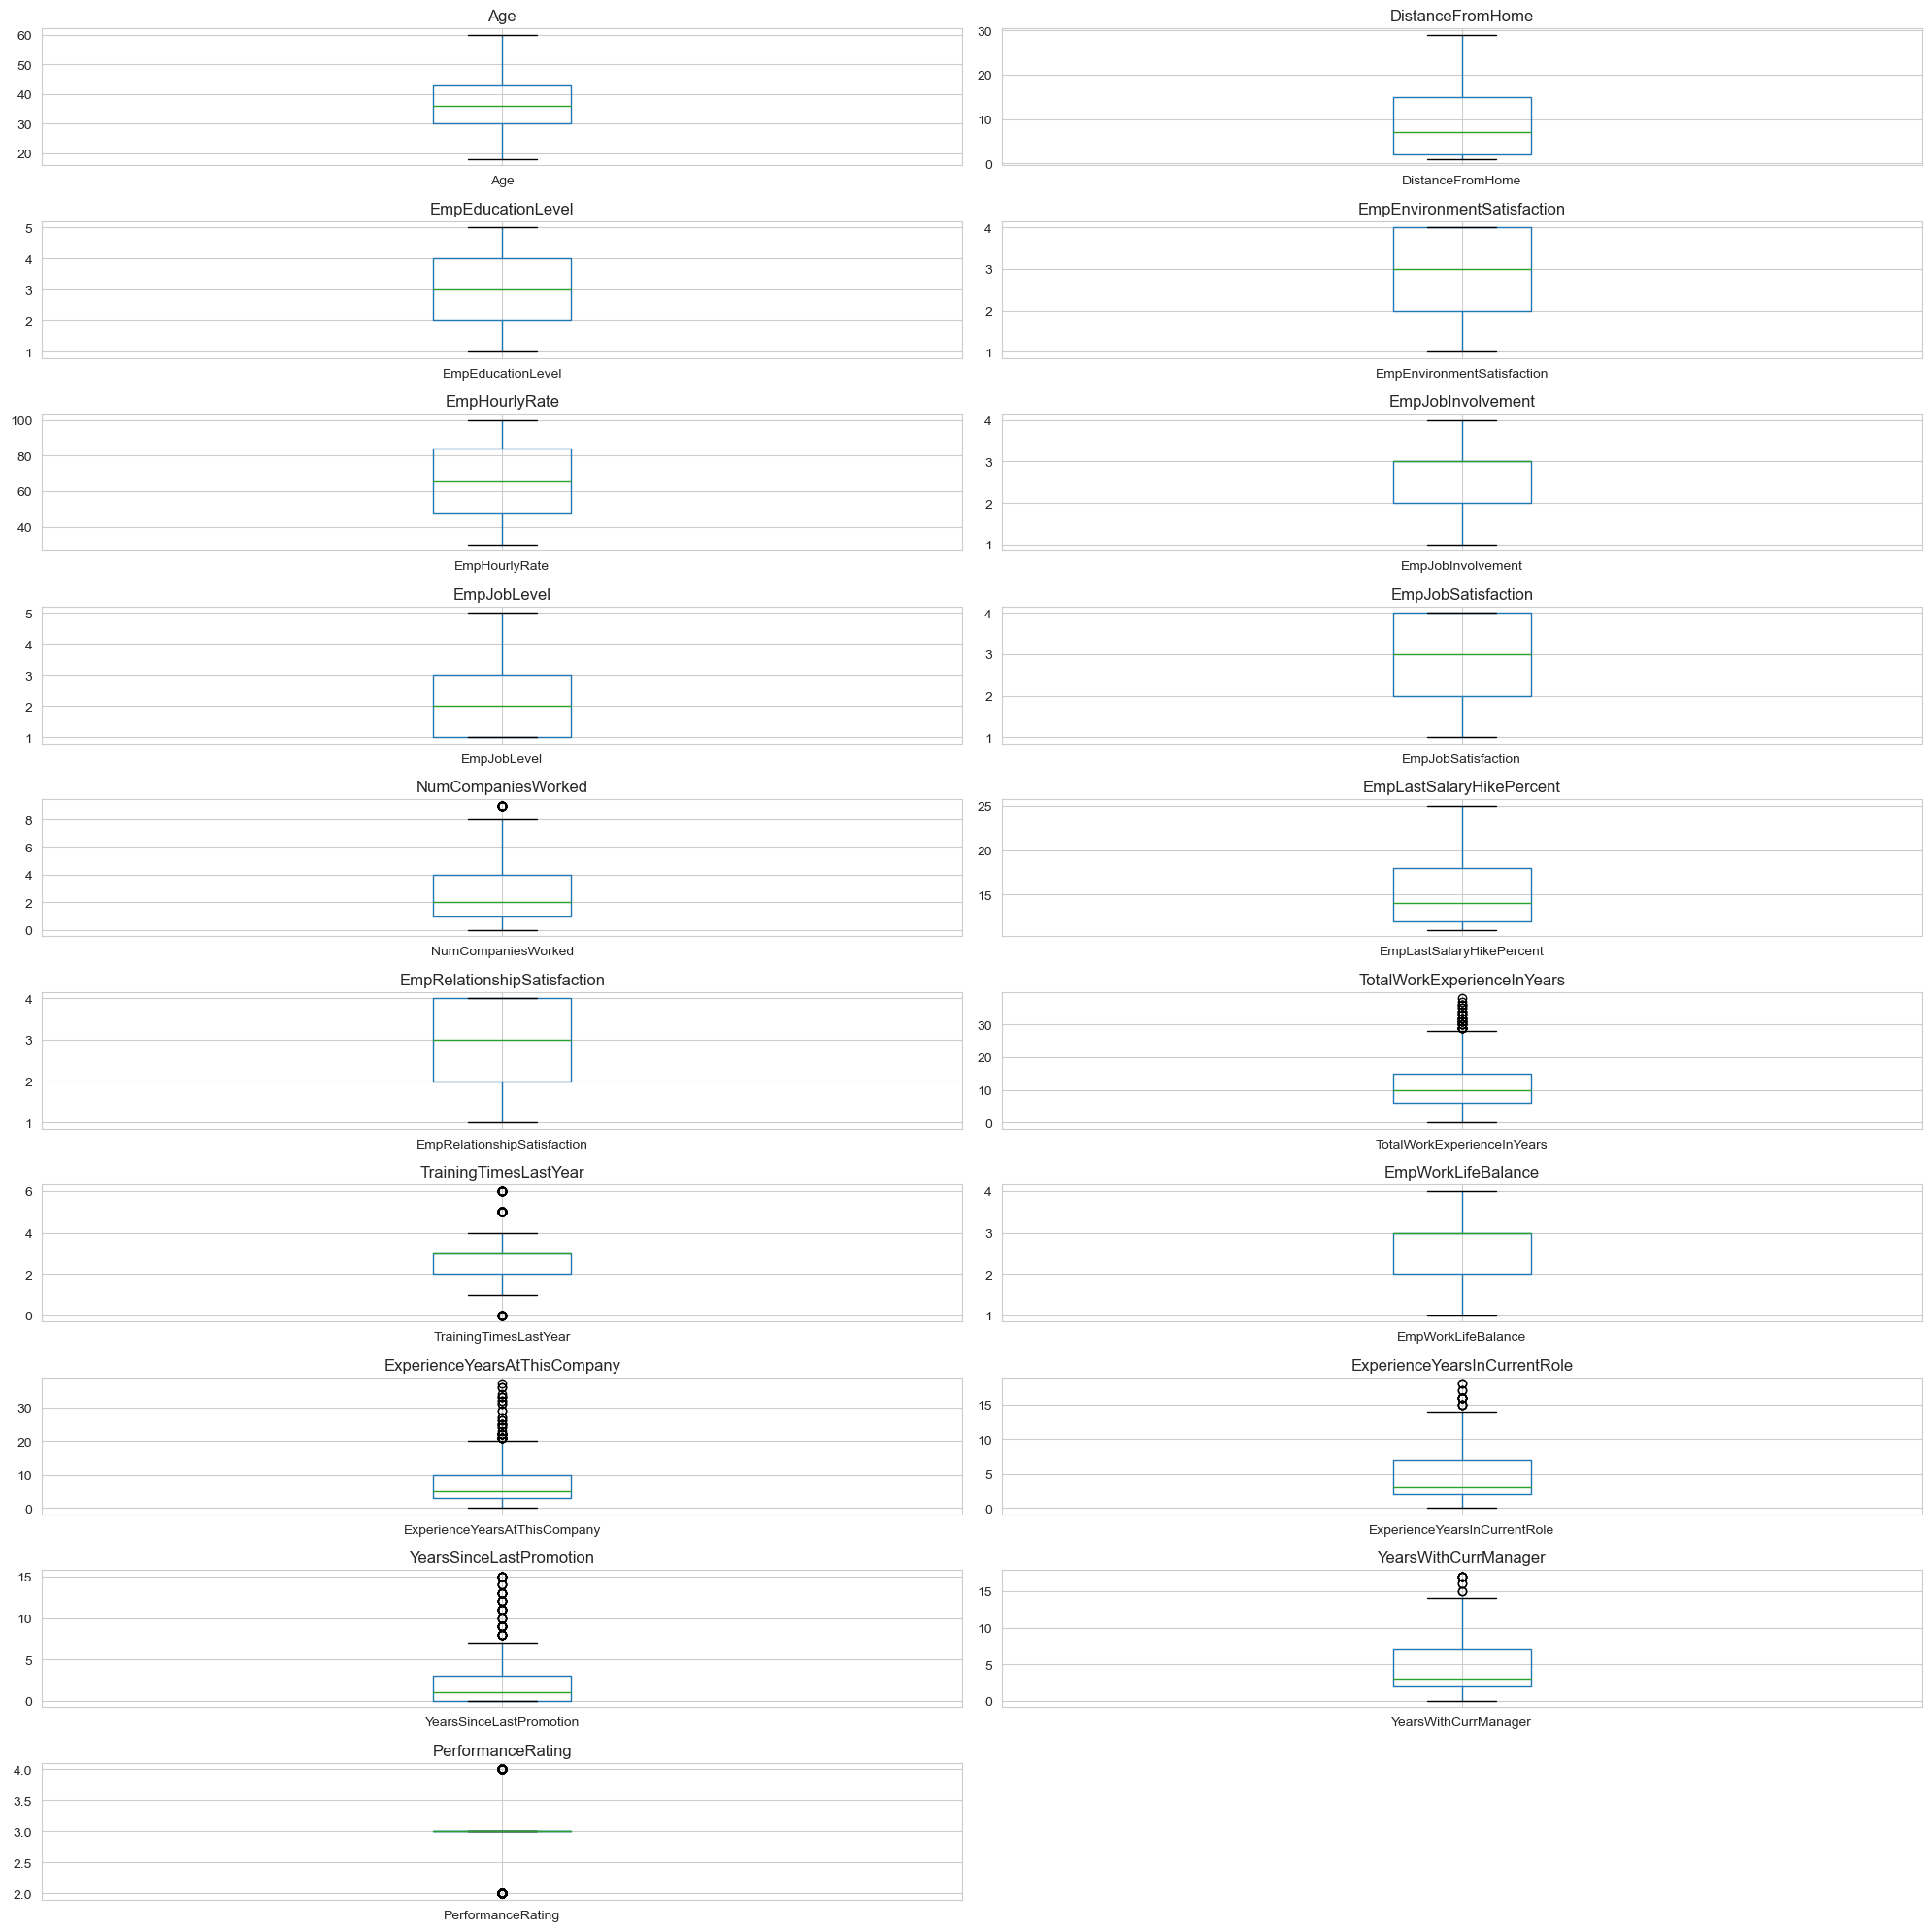

In [11]:
numerical_cols = df.select_dtypes("number")

ncols = 2
nrows = 10
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))

for i, column in enumerate(numerical_cols):
    ax = axes[i // ncols, i % ncols]
    df.boxplot(column=column, ax=ax)
    ax.set_title(column)

plt.delaxes(axes[-1,-1])
plt.tight_layout()
plt.show()

In [12]:
def handle_outliers(df):
    numerical_cols = df.select_dtypes("number").drop(['PerformanceRating'],axis = 1)
    z = np.abs(stats.zscore(numerical_cols))
    threshold = 3
    outliers = np.where(z > threshold)
    print(f"Using 'Z-Score Index we found there are {len(outliers[0])} Outliers")
    
    for col in numerical_cols.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
    z = np.abs(stats.zscore(df[numerical_cols.columns]))
    threshold = 3
    outliers = np.where(z > threshold)
    print(f"After handling outlier using IQR method we found there are {len(outliers[0])} Outliers")


In [13]:
handle_outliers(df)

Using 'Z-Score Index we found there are 73 Outliers
After handling outlier using IQR method we found there are 0 Outliers


# Encoding Categorical Variables

In [14]:
cat_cols = df.select_dtypes("object")

In [15]:
cat_cols.head()

,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,OverTime,Attrition
331,Male,Life Sciences,Divorced,Research & Development,Research Scientist,Travel_Rarely,No,No
409,Female,Medical,Single,Human Resources,Human Resources,Travel_Rarely,No,No
76,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Rarely,Yes,No
868,Male,Marketing,Single,Sales,Sales Representative,Travel_Rarely,Yes,Yes
138,Male,Other,Divorced,Sales,Sales Executive,Travel_Rarely,No,No


In [16]:
df.shape

(960, 27)

In [17]:
def encode_cat_feats(df):
    cat_cols = df.select_dtypes("object")
    cat_cols_list = cat_cols.columns.to_list()
    encoded_df = pd.get_dummies(df, columns=cat_cols_list, drop_first=True)
    performance_rating_column = encoded_df.pop('PerformanceRating')
    encoded_df['PerformanceRating'] = performance_rating_column
    encoded_df['PerformanceRating'] = encoded_df['PerformanceRating'].map({2: 0, 3: 1, 4: 2})
    return encoded_df

In [18]:
encoded_df = encode_cat_feats(df)

In [19]:
encoded_df.shape

(960, 54)

In [20]:
encoded_df.head()

,Age,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,EmpJobSatisfaction,NumCompaniesWorked,EmpLastSalaryHikePercent,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Gender_Male,EducationBackground_Life Sciences,EducationBackground_Marketing,EducationBackground_Medical,EducationBackground_Other,EducationBackground_Technical Degree,MaritalStatus_Married,MaritalStatus_Single,EmpDepartment_Development,EmpDepartment_Finance,EmpDepartment_Human Resources,EmpDepartment_Research & Development,EmpDepartment_Sales,EmpJobRole_Data Scientist,EmpJobRole_Delivery Manager,EmpJobRole_Developer,EmpJobRole_Finance Manager,EmpJobRole_Healthcare Representative,EmpJobRole_Human Resources,EmpJobRole_Laboratory Technician,EmpJobRole_Manager,EmpJobRole_Manager R&D,EmpJobRole_Manufacturing Director,EmpJobRole_Research Director,EmpJobRole_Research Scientist,EmpJobRole_Sales Executive,EmpJobRole_Sales Representative,EmpJobRole_Senior Developer,EmpJobRole_Senior Manager R&D,EmpJobRole_Technical Architect,EmpJobRole_Technical Lead,BusinessTravelFrequency_Travel_Frequently,BusinessTravelFrequency_Travel_Rarely,OverTime_Yes,Attrition_Yes,PerformanceRating
331,58,23,4,1,88,3,1,3,1.0,12,4,2.0,3.0,3,2.0,2.0,2.0,2.0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
409,31,8,2,4,96,4,1,2,8.5,18,4,8.0,3.0,3,3.0,2.0,0.0,2.0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
76,36,1,2,2,56,3,2,4,1.0,14,4,18.0,1.0,2,18.0,14.0,4.0,11.0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1
868,19,22,1,4,50,3,1,3,1.0,19,4,0.0,2.0,2,0.0,0.0,0.0,0.0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1
138,30,8,2,3,62,3,3,3,5.0,11,1,10.0,2.0,4,8.0,4.0,7.0,7.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1


# Save Preprocessed Data

In [21]:
import pandas as pd
import os

output_folder = os.path.join('..', '..', 'Data', 'Processed')
output_file_path = os.path.join(output_folder, 'data_processed.csv')
encoded_df.to_csv(output_file_path, index=False)